In [91]:
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Modeling
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [32]:
sentiment = pd.read_csv('daily_sentiment.csv')
sentiment['date'] = pd.to_datetime(sentiment['date'])
stock_universe = pd.read_pickle('stock_universe.pkl')

In [33]:
stocks = stock_universe[stock_universe.ticker.isin(['AMZN', 'AAPL', 'GOOG', 'MSFT','NVDA'])]
stocks.reset_index(drop = True, inplace = True)
stocks

,ticker,date,adj_close,adj_volume,return,Mkt-RF_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta
0,AAPL,2018-01-09,41.320189,86335988.0,-0.000115,0.008756,-0.001232,-0.004926,-0.007597,-0.011452
1,AAPL,2018-01-10,41.310708,95839580.0,-0.000229,0.008775,-0.001056,-0.005217,-0.007099,-0.011424
2,AAPL,2018-01-11,41.545360,74670916.0,0.005680,0.007868,-0.000869,-0.005472,-0.007063,-0.011407
3,AAPL,2018-01-12,41.974372,101672320.0,0.010326,0.007796,-0.000790,-0.005381,-0.007251,-0.011504
4,AAPL,2018-01-16,41.761051,118263788.0,-0.005082,0.007936,-0.000954,-0.005445,-0.007099,-0.011467
...,...,...,...,...,...,...,...,...,...,...
6670,NVDA,2023-04-24,270.391139,32678946.0,-0.002839,0.011537,-0.007743,0.002696,-0.000870,-0.029270
6671,NVDA,2023-04-25,262.381994,36774922.0,-0.029621,0.011207,-0.007781,0.002511,-0.001182,-0.029258
6672,NVDA,2023-04-26,269.531231,40449391.0,0.027247,0.011268,-0.007532,0.002750,-0.001135,-0.029450
6673,NVDA,2023-04-27,272.230943,37426523.0,0.010016,0.011365,-0.007634,0.002580,-0.001063,-0.029480


In [37]:
df = stocks.merge(sentiment, how = 'outer',
                  left_on = ['date','ticker'],
                  right_on = ['date','ticker']).sort_values(by= ['ticker','date']).reset_index(drop = True)
df.sort_values(by= ['ticker','date'])

,ticker,date,adj_close,adj_volume,return,Mkt-RF_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,compound,neg,neu,pos,volume
0,AAPL,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.255300,0.000000,0.854000,0.146000,2.0
1,AAPL,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064093,0.093143,0.815571,0.091286,14.0
2,AAPL,2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.048510,0.066100,0.894500,0.039400,10.0
3,AAPL,2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.173443,0.053857,0.784000,0.162143,7.0
4,AAPL,2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008500,0.068000,0.854200,0.078000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,NVDA,2023-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024525,0.028875,0.946125,0.025000,8.0
9461,NVDA,2023-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.170586,0.024643,0.853214,0.122143,14.0
9462,NVDA,2023-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.189127,0.097545,0.902455,0.000000,11.0
9463,NVDA,2023-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121033,0.027222,0.888333,0.084444,9.0


After merging the stock data and related sentimental analysis, we can see a lot of missing values. This is because the stock market is closed on weekends and holidays, while the news is still being reported.

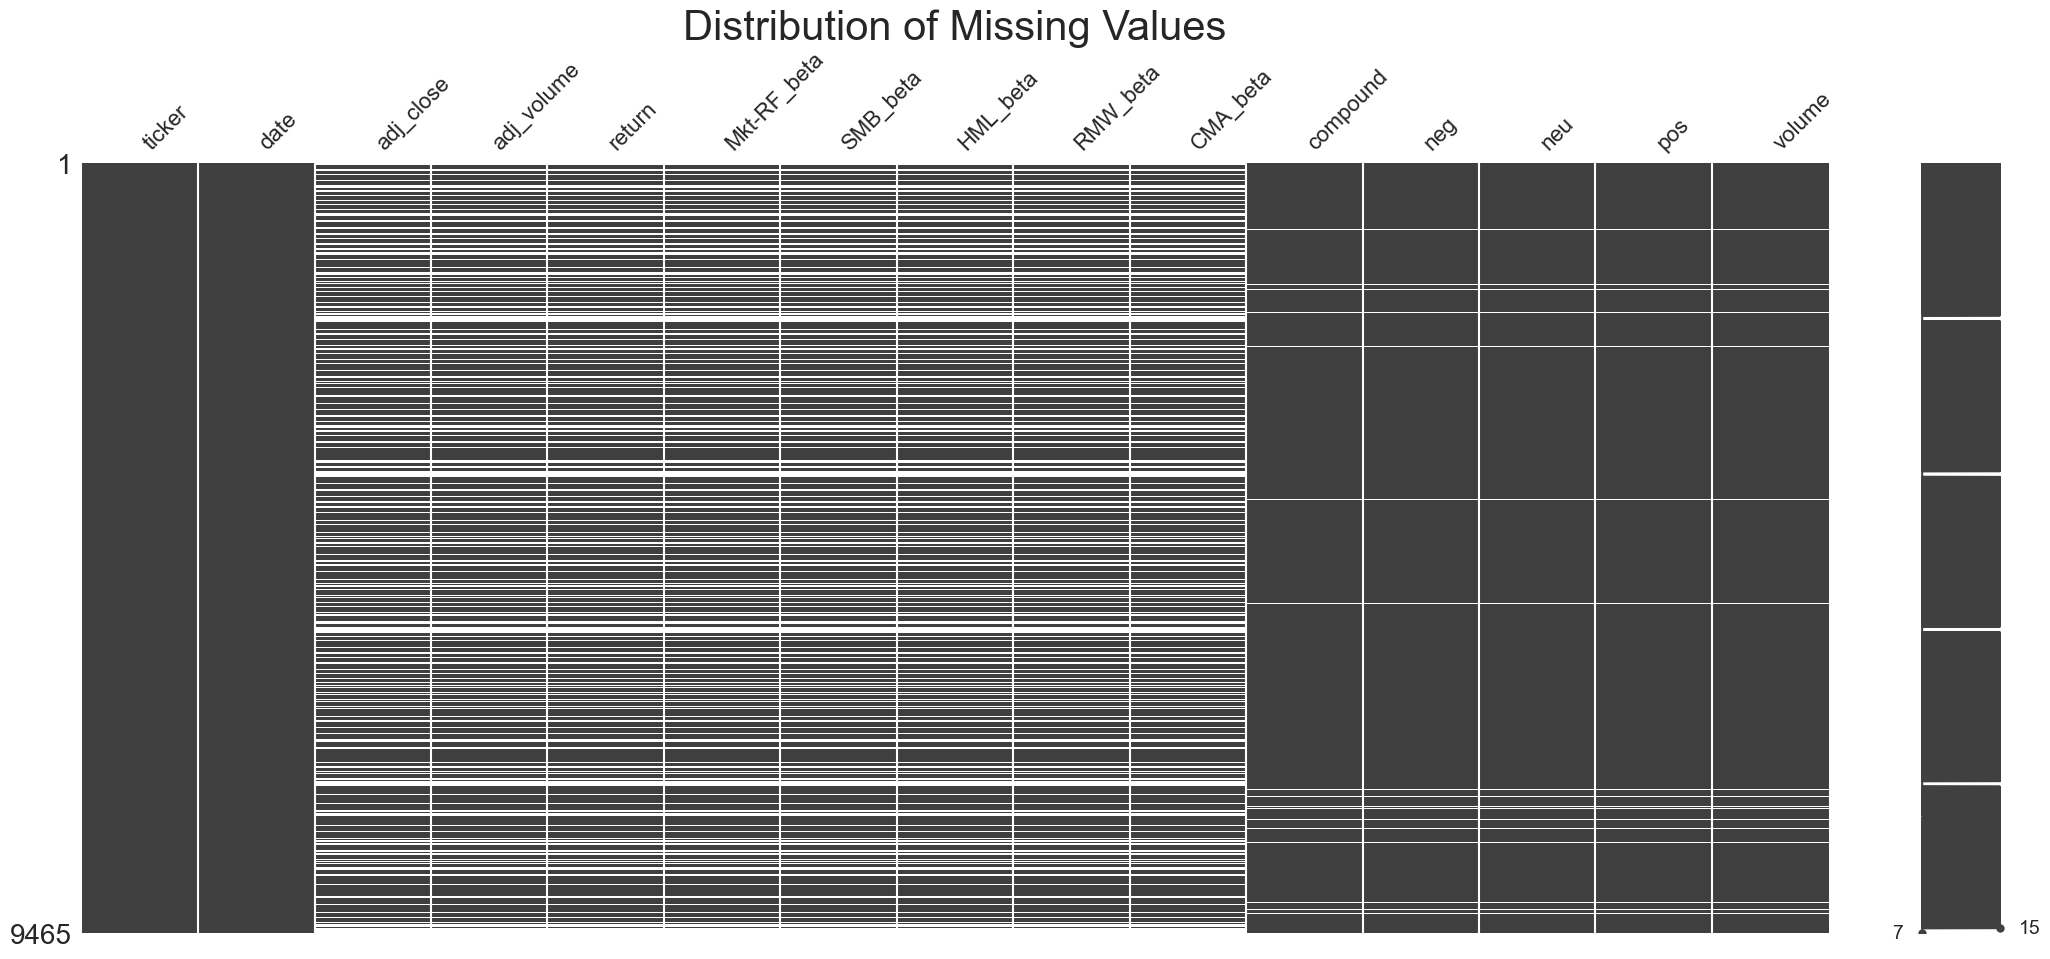

In [39]:
msno.matrix(df)
plt.title("Distribution of Missing Values", fontsize = 30)
None

If we visualize the missing values, we can see that most missing values happen for stock data during weekends and holidays. Occasionally, there are mising values for news data. It means that, although we have chosen the most frequent and hot-spot companies, some firms' news are not reported on certain days.

However, since when market closes, the stock price will not change. In other words, all stock price information that the investors get and use for analysis or speculation is previous available data. Thus, we can use the previous trading day's stock price to fill in the missing stock prices.

To fill the missing values for news data, we can use the previous day's news data to fill in the missing values and set volume to 0. This is because the news sentiment of the previous day is usually the same as the news sentiment of the current day. Although, the sentiment usually tends to be neutral as time passes, since the missing values are rare, we can simplify the process by using the previous sentiment.

In [66]:
df.iloc[:,2:14] = df.iloc[:,2:14].fillna(method = 'ffill')
df.iloc[15] = df.iloc[15].fillna(0)
df = df.dropna()
df

,ticker,date,adj_close,adj_volume,return,Mkt-RF_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,compound,neg,neu,pos,volume
8,AAPL,2018-01-09,41.320189,86335988.0,-0.000115,0.008756,-0.001232,-0.004926,-0.007597,-0.011452,-0.108533,0.081889,0.898222,0.019889,9.0
9,AAPL,2018-01-10,41.310708,95839580.0,-0.000229,0.008775,-0.001056,-0.005217,-0.007099,-0.011424,0.026117,0.103500,0.791167,0.105333,6.0
10,AAPL,2018-01-11,41.545360,74670916.0,0.005680,0.007868,-0.000869,-0.005472,-0.007063,-0.011407,-0.053582,0.064909,0.872909,0.062182,11.0
11,AAPL,2018-01-12,41.974372,101672320.0,0.010326,0.007796,-0.000790,-0.005381,-0.007251,-0.011504,0.051225,0.069750,0.855125,0.075125,8.0
12,AAPL,2018-01-14,41.974372,101672320.0,0.010326,0.007796,-0.000790,-0.005381,-0.007251,-0.011504,-0.204700,0.110500,0.889500,0.000000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,NVDA,2023-06-26,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,-0.024525,0.028875,0.946125,0.025000,8.0
9461,NVDA,2023-06-27,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,0.170586,0.024643,0.853214,0.122143,14.0
9462,NVDA,2023-06-28,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,-0.189127,0.097545,0.902455,0.000000,11.0
9463,NVDA,2023-06-29,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,0.121033,0.027222,0.888333,0.084444,9.0


In [67]:
summary_stats = df.describe()
summary_stats

,adj_close,adj_volume,return,Mkt-RF_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,compound,neg,neu,pos,volume
count,9258.000000,9.258000e+03,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000
mean,126.997332,6.234553e+07,0.000692,0.011959,-0.002722,-0.003428,0.001805,-0.007368,0.079193,0.048876,0.845510,0.105615,6.147332
std,68.664335,4.821300e+07,0.023408,0.003057,0.003731,0.003868,0.005400,0.011889,0.170526,0.058267,0.101017,0.086152,3.947328
min,31.528513,6.935060e+06,-0.187559,0.000383,-0.016177,-0.019271,-0.020649,-0.045892,-0.824000,0.000000,0.303000,0.000000,1.000000
25%,72.866543,2.841904e+07,-0.010476,0.010209,-0.005165,-0.005720,-0.001219,-0.013786,0.000000,0.000000,0.783446,0.041571,3.000000
50%,112.799000,4.787815e+07,0.001051,0.011755,-0.002865,-0.003108,0.002206,-0.008551,0.070094,0.036000,0.856400,0.091950,6.000000
75%,160.193679,8.028166e+07,0.012172,0.013359,-0.000543,-0.000850,0.004958,-0.000855,0.172380,0.073229,0.914729,0.159000,9.000000
max,338.297561,4.184741e+08,0.171564,0.023148,0.009848,0.009202,0.023862,0.028699,0.942300,0.576000,1.000000,0.667000,39.000000


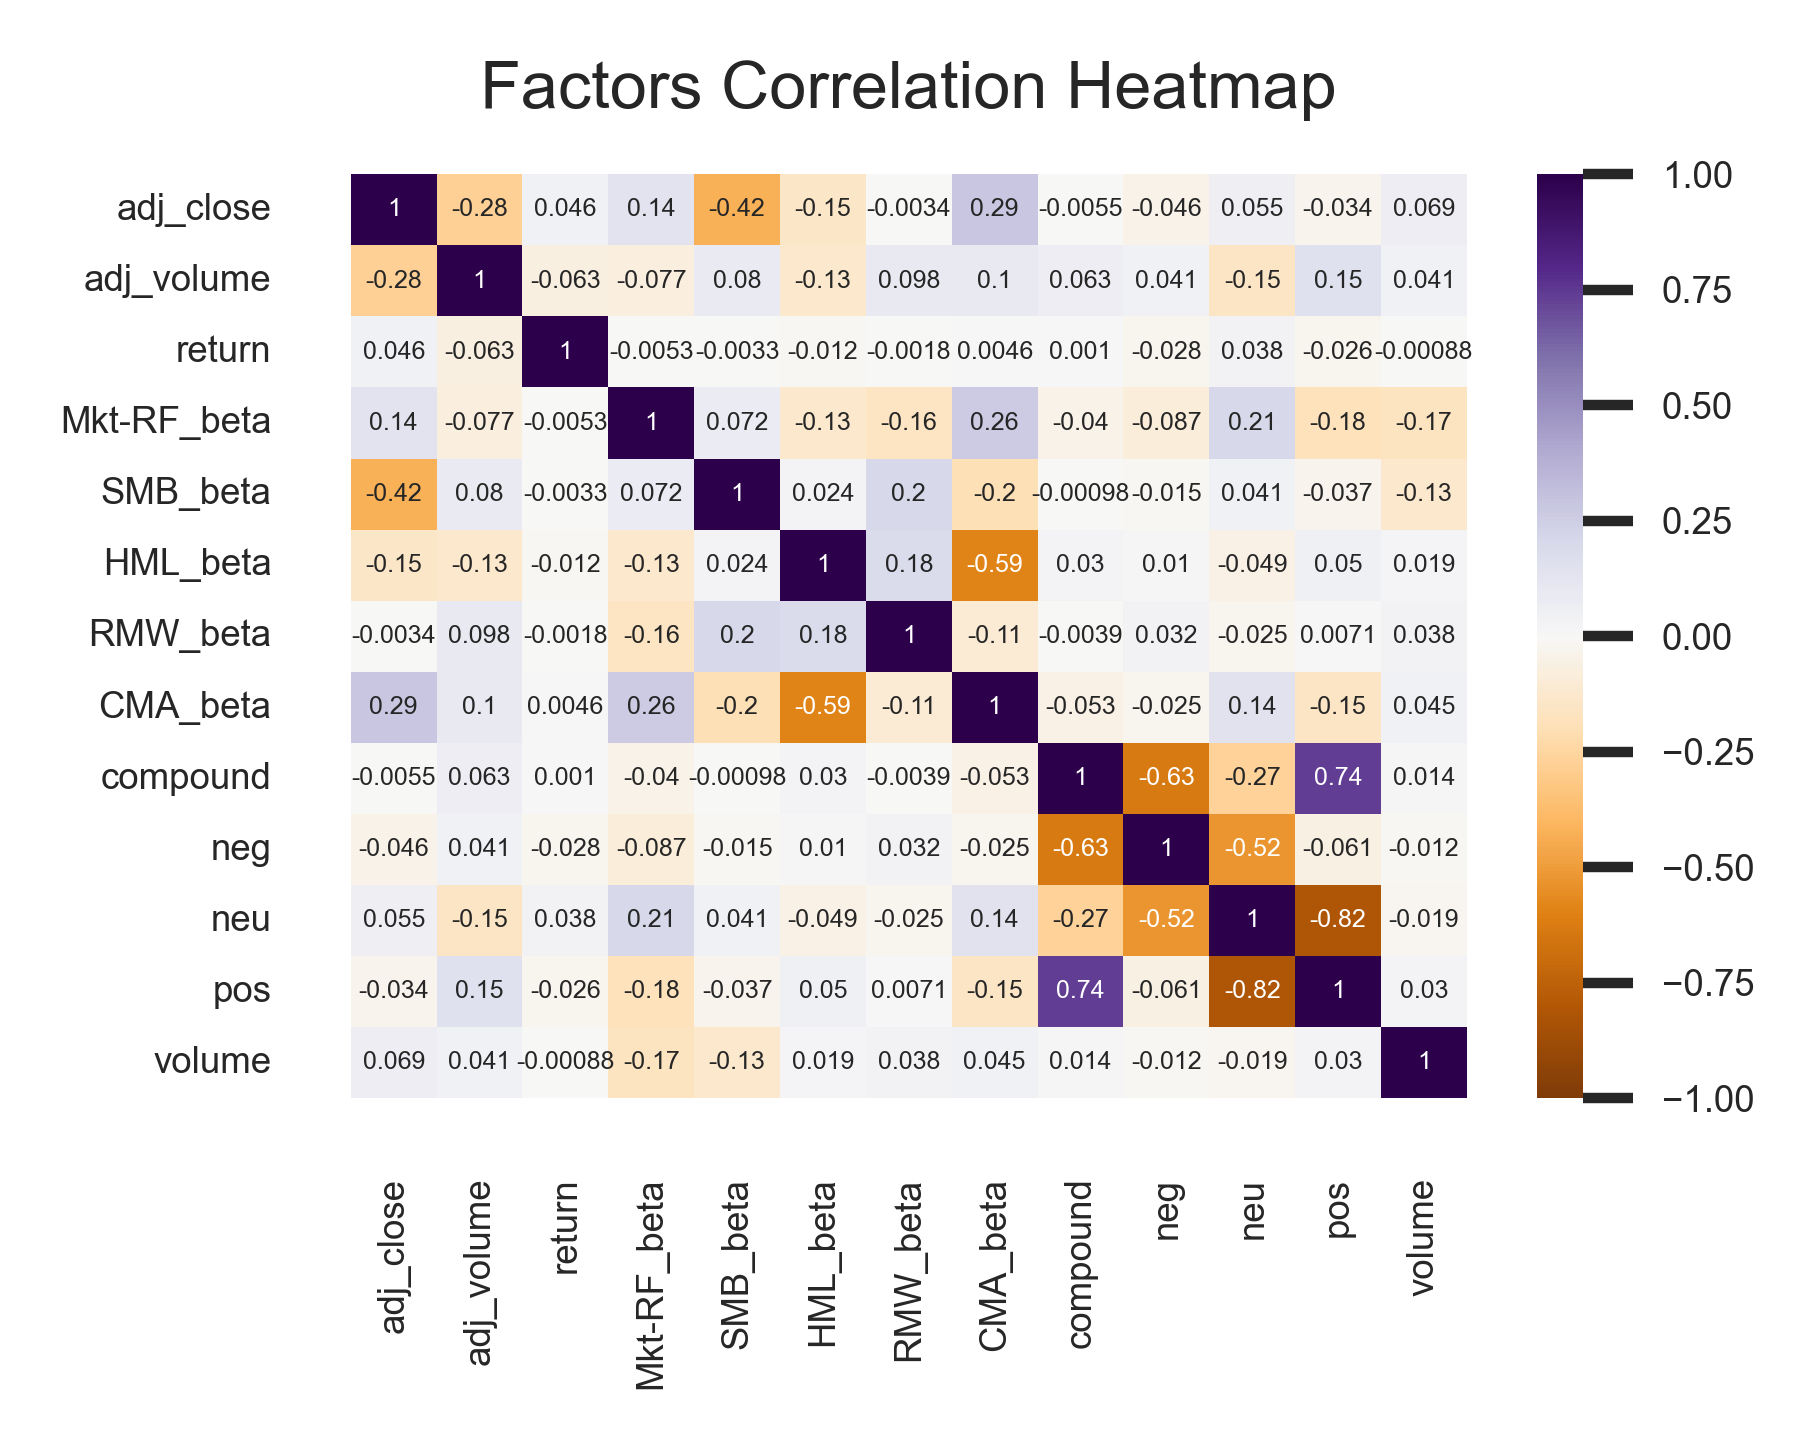

In [68]:
plt.figure(figsize=(3,2),dpi=600)
sns.set(font_scale=0.4)
heatmap = sns.heatmap(df.corr(), cmap="PuOr",vmin=-1, vmax=1, annot=True,annot_kws={"size": 3})
heatmap.set_title('Factors Correlation Heatmap', fontdict={'fontsize':8}, pad=8);

From the correlation heatmap, we can see a dominant negative correlations between CMA beta and HML beta. This may cause a concern about collinearity in our future model. There is one interest fact from this heatmap is that the neutral sentiment and market beta are correlated which means that the excess return of the equity is more likely to increase when the news sentiment is neutral and the return is defined by the risk premium of the equity itself.

Since most factors do not have high correlation, it is reasonable for us to try linear regression model first.

As all betas are calculated by the past 100 days exclude today's closing price, and we can get the news sentiment by the end of the day, we can use contemporaneous model to predict the return of the next day.

## Linear Regression Model

In [98]:
X = df.loc[:,['adj_volume','Mkt-RF_beta','SMB_beta','HML_beta','RMW_beta','CMA_beta','compound','neg','neu','pos','volume']]
y = df.loc[:,'adj_close']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     422.3
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               0.00
Time:                        23:30:52   Log-Likelihood:                -50406.
No. Observations:                9258   AIC:                         1.008e+05
Df Residuals:                    9246   BIC:                         1.009e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          44.3798   7012.383      0.006      

Without the prediction process, simply from the fitting summary, we can conclude that linear regression model cannot properly replicate the return of the next day. The R-squared is only 0.006, which means that the model cannot explain the variation of the return. The coefficients of the factors are all statistically insignificant because of the high p-value. The F-statistic is also very low, which means that the model is not statistically significant. Thus, we should find other non-linear models to predict the return.

## Random Forest Model

In [99]:
X_train = df[df.date <= '2021-12-31'].loc[:,['adj_volume','Mkt-RF_beta','SMB_beta','HML_beta','RMW_beta','CMA_beta','compound','neg','neu','pos','volume']].values
y_train = df[df.date <= '2021-12-31'].loc[:,'adj_close'].values
X_test = df[df.date >= '2022-01-01'].loc[:,['adj_volume','Mkt-RF_beta','SMB_beta','HML_beta','RMW_beta','CMA_beta','compound','neg','neu','pos','volume']].values
y_test = df[df.date >= '2022-01-01'].loc[:,'adj_close'].values

In [100]:
rf_model = RandomForestRegressor(random_state=1)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search to tune the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]})

In [101]:
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

best_hyperparams = grid_search.best_params_
print("Best Hyperparameters:")
print(best_hyperparams)

Best Hyperparameters:
{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}


In [113]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

r_squared = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r_squared:.4f}")

pd.DataFrame([np.sqrt(mse),mae], index = ['RMSE','MAE'], columns = ['Random Forest Model'])

Mean Squared Error: 4672.3777
Mean Absolute Error (MAE): 46.9820
R-squared (R²): -0.0610


,Random Forest Model
RMSE,68.354793
MAE,46.982017


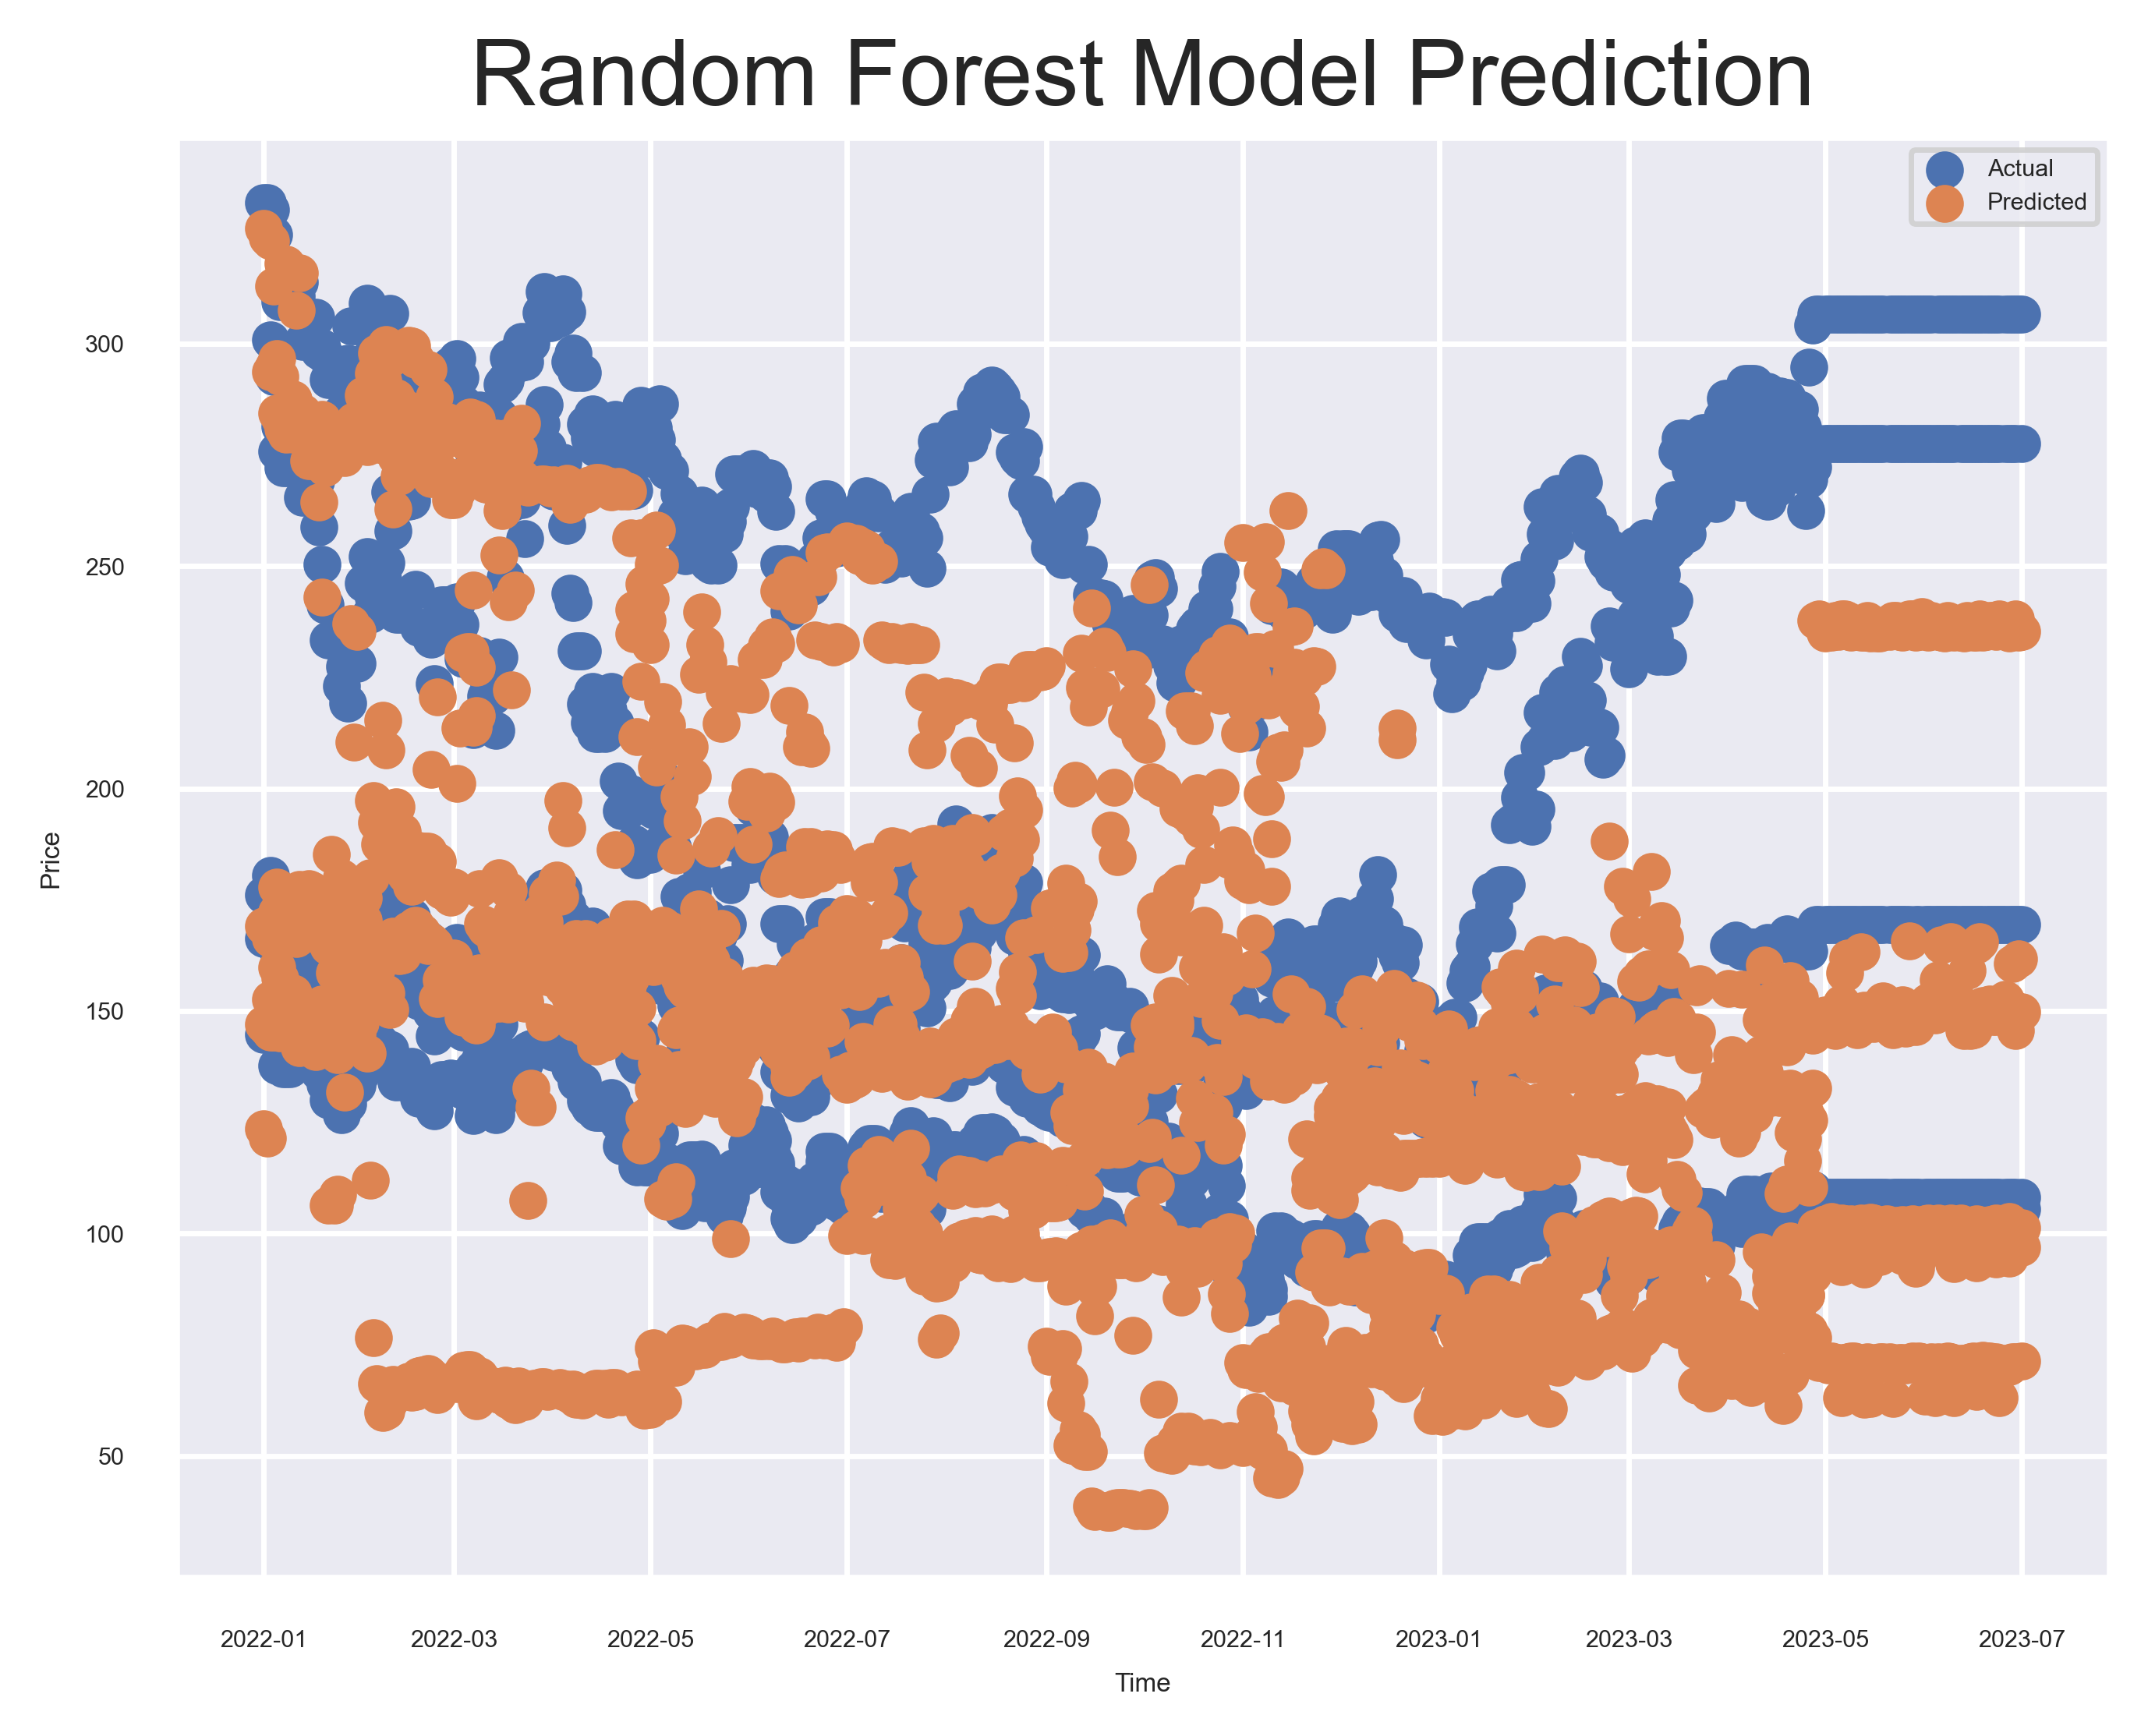

In [112]:
plt.figure(dpi=500)
plt.scatter(df[df.date >= '2022-01-01'].date, y_test, label = 'Actual')
plt.scatter(df[df.date >= '2022-01-01'].date, y_pred, label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Random Forest Model Prediction', fontsize = 17)
plt.legend()
None

,ticker,date,adj_close,adj_volume,return,Mkt-RF_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,compound,neg,neu,pos,volume
1407,AAPL,2022-01-01,176.032004,61661433.0,-0.003535,0.011895,-0.002160,-0.011910,0.003169,0.020981,-0.230133,0.116667,0.883333,0.000000,3.0
1408,AAPL,2022-01-02,176.032004,61661433.0,-0.003535,0.011895,-0.002160,-0.011910,0.003169,0.020981,-0.359700,0.200000,0.800000,0.000000,1.0
1409,AAPL,2022-01-03,180.433547,96490749.0,0.025004,0.011919,-0.002150,-0.011869,0.003184,0.020972,0.199271,0.038286,0.782000,0.179714,7.0
1410,AAPL,2022-01-04,178.143555,92663116.0,-0.012692,0.012006,-0.002576,-0.011831,0.002444,0.021659,0.034217,0.043000,0.919083,0.037917,12.0
1411,AAPL,2022-01-05,173.404956,94031550.0,-0.026600,0.011959,-0.002347,-0.011721,0.002546,0.021393,0.067133,0.055667,0.846111,0.098222,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,NVDA,2023-06-26,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,-0.024525,0.028875,0.946125,0.025000,8.0
9461,NVDA,2023-06-27,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,0.170586,0.024643,0.853214,0.122143,14.0
9462,NVDA,2023-06-28,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,-0.189127,0.097545,0.902455,0.000000,11.0
9463,NVDA,2023-06-29,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,0.121033,0.027222,0.888333,0.084444,9.0
